In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set(rc={'figure.figsize':(9, 3)})
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Load LULESH data

In [2]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for spread in [2,4,6,8,9,10,12]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/daint_gpu/lulesh_27/lulesh_{spread}/lulesh_*.out')):

        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed time", fp):
                size = int(f.split('_')[-2])
                data.append([spread, size, float(line.split()[-2])])
                
lulesh_time = pd.DataFrame(data=data, columns=['spread', 'lulesh_size', 'time'])
normal_lulesh = lulesh_time.loc[lulesh_time['spread'] == 9]
#print(normal_lulesh)

avg_lulesh = normal_lulesh.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['lulesh_size']).std().reset_index()


# Load GPU Data

In [3]:

def lines_that_contain(string, fp):
    return [line for line in fp if string in line]

data = []

for app in ["bfs", "gaussian", "hotspot", "myocyte", "pathfinder", "srad-v1"]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline_gpu/{app}/*.out')):
        #print(f)
        with open(f, 'r') as fp:
            line = fp.readline()
            #print(line)
            data.append([app, float(line)])
            #or line in lines_that_contain("in seconds", fp):
            #    size = f.split('_')[-2]
            #    benchmark = f.split('_')[-3]
            #    data.append([p, benchmark, size, float(line.split()[-1])])
#print(data)
gpu_time = pd.DataFrame(data=data, columns=['app', 'time'])
#nas_container['type'] = nas_container.apply(lambda row: f"({row['benchmark'].upper()}, {row['size']})", axis=1)
#nas_container.sort_values(by=['type'], inplace=True)
mean_gpu = gpu_time.groupby(['app']).mean()
dev_gpu = gpu_time.groupby(['app']).std()

print('Mean', mean_gpu)
print('CoV', gpu_time.groupby(['app']).std() / mean_gpu)

Mean                 time
app                 
bfs         1.632161
gaussian    0.288101
hotspot     0.437144
myocyte     0.444882
pathfinder  0.340984
srad-v1     0.176451
CoV                 time
app                 
bfs         0.002082
gaussian    0.079722
hotspot     0.008973
myocyte     0.007055
pathfinder  0.029771
srad-v1     0.049793


# Co-located LULESH

In [4]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for app in ["bfs", "gaussian", "hotspot", "myocyte", "pathfinder", "srad-v1"]:
    
    for lulesh_size in [15,18,20,25]:
        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_gpu/lulesh/nas_{lulesh_size}_{app}/lulesh*.out')):
            
            with open(f, 'r') as fp:
                for line in lines_that_start_with("Elapsed time", fp):
                    data.append([lulesh_size, app, float(line.split()[-2])])

colocated_lulesh = pd.DataFrame(data=data, columns=['lulesh_size', 'app', 'time'])
colocated_lulesh = pd.DataFrame(data=data, columns=['lulesh_size', 'app', 'time'])
#print(colocated_lulesh)
#print(lulesh_time.loc[lulesh_time['size'] == 10]['time'])


# Co-located GPU

In [5]:
data = []

for app in ["bfs", "gaussian", "hotspot", "myocyte", "pathfinder", "srad-v1"]:
    
    for lulesh_size in [15,18,20,25]:
        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_gpu/lulesh/nas_{lulesh_size}_{app}/{app}*.out')):
            #print(f)
            with open(f, 'r') as fp:
                line = fp.readline()
                if line != "":
                    data.append([lulesh_size, app, float(line)])

colocated_gpu = pd.DataFrame(data=data, columns=['lulesh_size', 'app', 'time'])
#print(colocated_gpu)

# Compute slowdown data

In [6]:

mean_colocated_lulesh = colocated_lulesh.groupby(['lulesh_size', 'app']).mean().reset_index()
median_colocated_lulesh = colocated_lulesh.groupby(['lulesh_size', 'app']).median().reset_index()
dev_colocated_lulesh = colocated_lulesh.groupby(['lulesh_size', 'app']).std().reset_index()
mean_lulesh = normal_lulesh.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['lulesh_size']).std().reset_index()

mean_colocated_gpu = colocated_gpu.groupby(['lulesh_size', 'app']).mean().reset_index()
median_colocated_gpu = colocated_gpu.groupby(['lulesh_size', 'app']).median().reset_index()
dev_colocated_gpu = colocated_gpu.groupby(['lulesh_size', 'app']).std().reset_index()
mean_gpu = gpu_time.groupby(['app']).mean().reset_index()
median_gpu = gpu_time.groupby(['app']).median().reset_index()
dev_gpu = gpu_time.groupby(['app']).std().reset_index()


df1 = mean_colocated_lulesh.set_index('lulesh_size')
df2 = mean_lulesh.set_index('lulesh_size')
df1['original_time'] = df2['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']
df1['original_dev'] = dev_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['dev'] = dev_colocated_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['slowdown_dev'] = df1['slowdown']*np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

df3 = mean_colocated_gpu.set_index(['app'])
df4 = mean_gpu.set_index(['app'])
df3['original_time'] = df4['time'].reindex(df3.index)
df3['slowdown'] = df3['time'] / df3['original_time']
df3['original_dev'] = dev_gpu.set_index('app')['time'].reindex(df3.index)
df3['dev'] = dev_colocated_gpu.set_index('app')['time'].reindex(df3.index)
df3['slowdown_dev'] = df3['slowdown']*np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)

df5 = df1.reset_index().set_index(['app', 'lulesh_size'])
df6 = df3.reset_index().set_index(['app', 'lulesh_size'])

df5['app_slowdown'] = df6['slowdown'].reindex(df5.index)
df5['app_slowdown_dev'] = df6['slowdown_dev'].reindex(df5.index)
df5.reset_index(inplace=True)


df5['rescaled_slowdown'] = (df5['slowdown']-1)*100
df5['rescaled_app_slowdown'] = (df5['app_slowdown']-1)*100
df5['rescaled_slowdown_dev'] = df5['slowdown_dev']*100
df5['rescaled_app_slowdown_dev'] = df5['app_slowdown_dev']*100
df5

,app,lulesh_size,time,original_time,slowdown,original_dev,dev,slowdown_dev,app_slowdown,app_slowdown_dev,rescaled_slowdown,rescaled_app_slowdown,rescaled_slowdown_dev,rescaled_app_slowdown_dev
0,bfs,15,26.235938,24.496639,1.071002,0.039064,3.620536,0.147807,1.083787,0.049202,7.100154,8.378744,14.780713,4.920167
1,gaussian,15,25.492928,24.496639,1.040670,0.039064,1.076884,0.043992,0.966791,0.080860,4.067045,-3.320855,4.399181,8.085953
2,hotspot,15,24.865745,24.496639,1.015068,0.039064,0.178775,0.007475,1.052067,0.024689,1.506765,5.206677,0.747530,2.468927
3,myocyte,15,24.867238,24.496639,1.015129,0.039064,0.254563,0.010517,0.989183,0.013681,1.512857,-1.081672,1.051708,1.368123
4,pathfinder,15,26.050602,24.496639,1.063436,0.039064,3.043090,0.124236,1.051201,0.036609,6.343577,5.120124,12.423636,3.660856
5,srad-v1,15,25.881144,24.496639,1.056518,0.039064,0.853074,0.034865,1.007432,0.071952,5.651820,0.743211,3.486485,7.195164
6,bfs,18,49.820851,48.323378,1.030989,0.163655,1.678534,0.034910,1.092144,0.036460,3.098859,9.214449,3.491049,3.645982
7,gaussian,18,49.652031,48.323378,1.027495,0.163655,0.837277,0.017673,0.953198,0.081270,2.749505,-4.680247,1.767252,8.127012
8,hotspot,18,49.019564,48.323378,1.014407,0.163655,0.304922,0.007185,1.049770,0.017492,1.440682,4.977007,0.718462,1.749190
9,myocyte,18,48.978858,48.323378,1.013564,0.163655,0.425765,0.009456,0.984460,0.016813,1.356445,-1.554023,0.945580,1.681285


# Plot LULESH

In [7]:
def barplot_err(x, y, xerr=None, yerr=None, data=None, hue=None, **kwargs):

    y_values = []
    yerr_values = []
    for hue_value in data[hue].unique():
        for x_value in data[x].unique():
            row = data.loc[(data[hue] == hue_value) & (data[x] == x_value)]
            y_values.append(row[y].values[0])
            yerr_values.append(row[yerr].values[0])
        
    _ax = sns.barplot(x=x,y=y,data=data, hue=hue, **kwargs)
    
    x_coords = [p.get_x() + 0.5*p.get_width() for p in _ax.patches]
    y_coords = [p.get_height() for p in ax.patches]

    _, caps,_ = _ax.errorbar(x=x_coords, y=y_coords, yerr=yerr_values, linewidth=2, 
                             solid_capstyle='round', solid_joinstyle='round', color='#464646', fmt="none", capsize=4.5)
    

    for cap in caps:
        cap.set_markeredgewidth(2)
        cap._marker._capstyle = matplotlib._enums.CapStyle.round

    return _ax

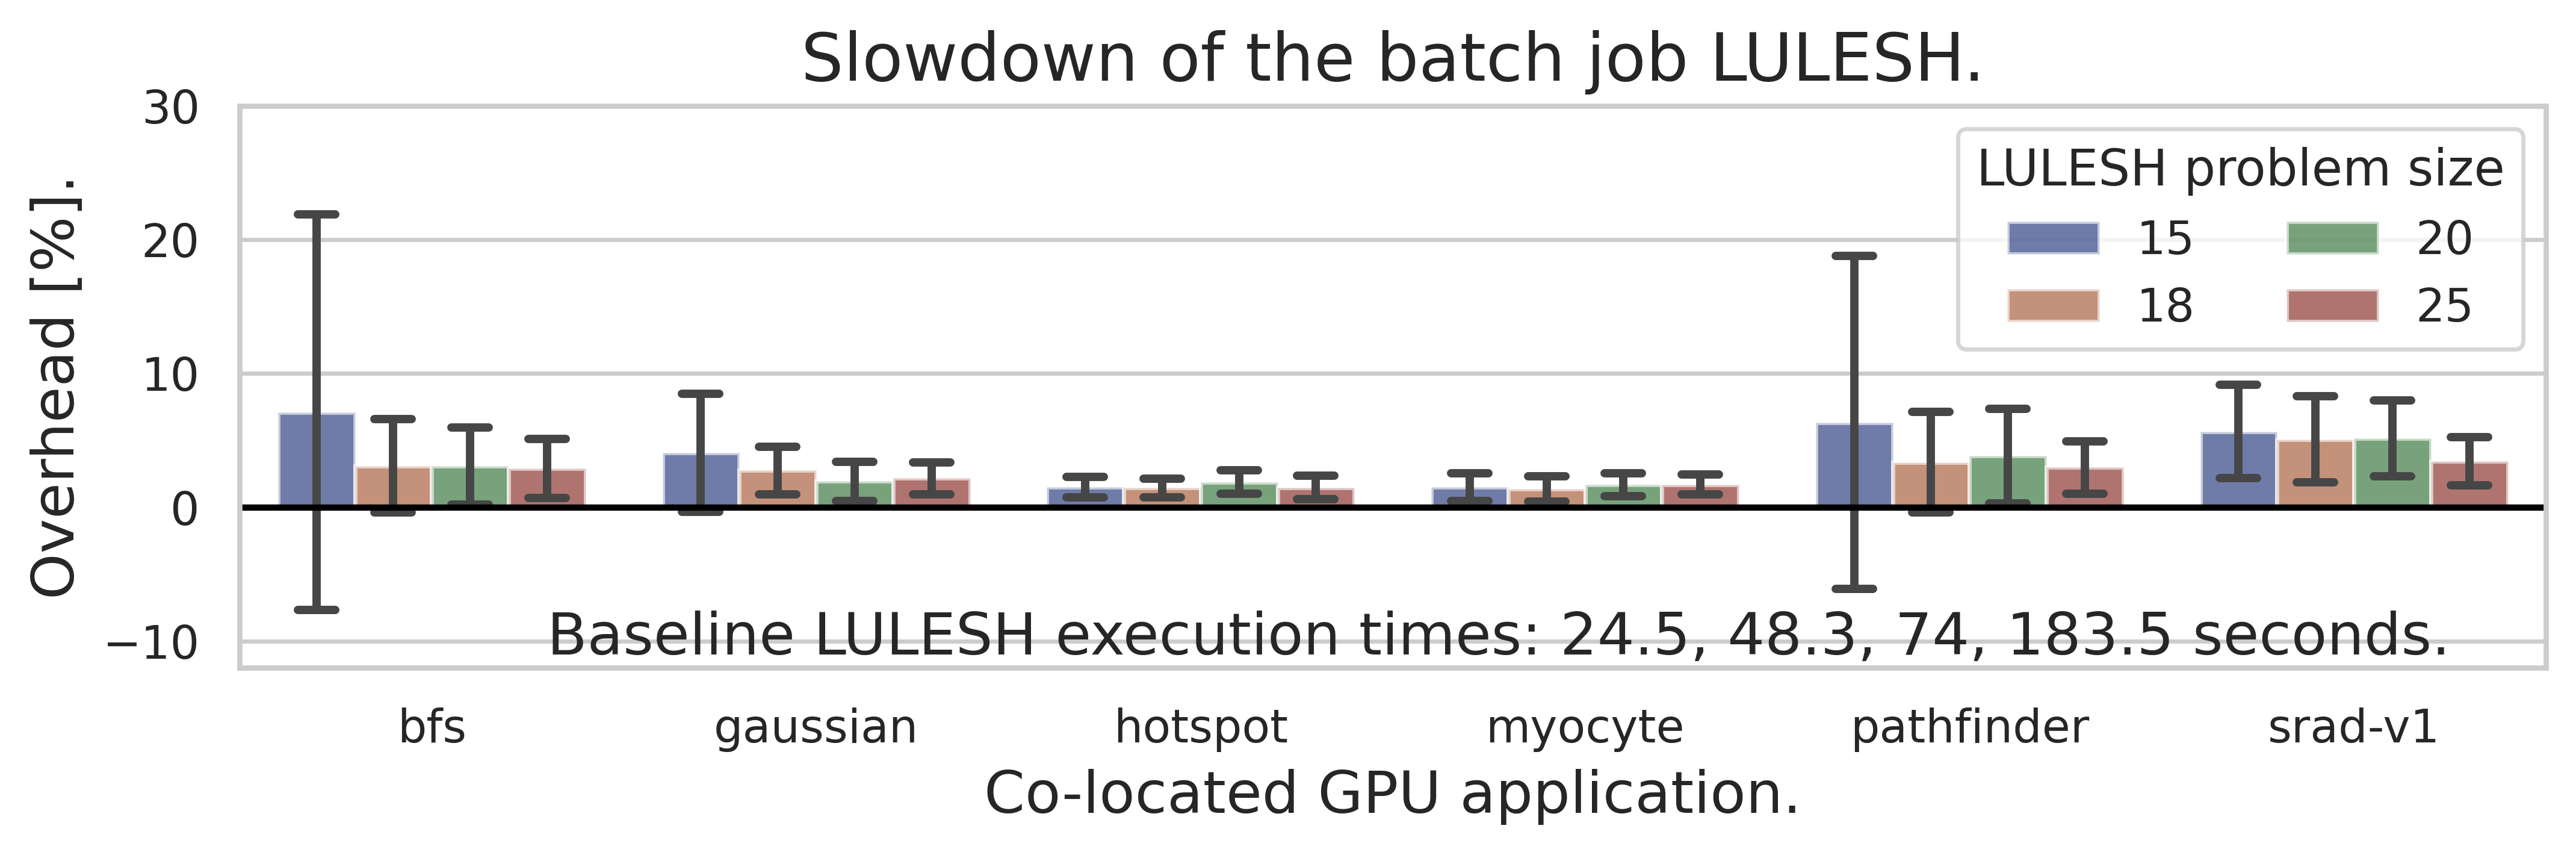

In [11]:

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df5,
#    x="app", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)

g = barplot_err(y="rescaled_slowdown", x="app", yerr="rescaled_slowdown_dev", hue="lulesh_size",
                data=df5,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located GPU application.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(title='LULESH problem size', ncol=2, loc='upper right')
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-12,30])
g.set_xlim([-0.5,5.5])

plt.annotate("Baseline LULESH execution times: 24.5, 48.3, 74, 183.5 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(1, -2),  #xycoords='data',
            xytext=(0.3, -11), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "gpu", "colocation_gpu_lulesh.pdf"), bbox_inches='tight',pad_inches = 0, transparent=False)


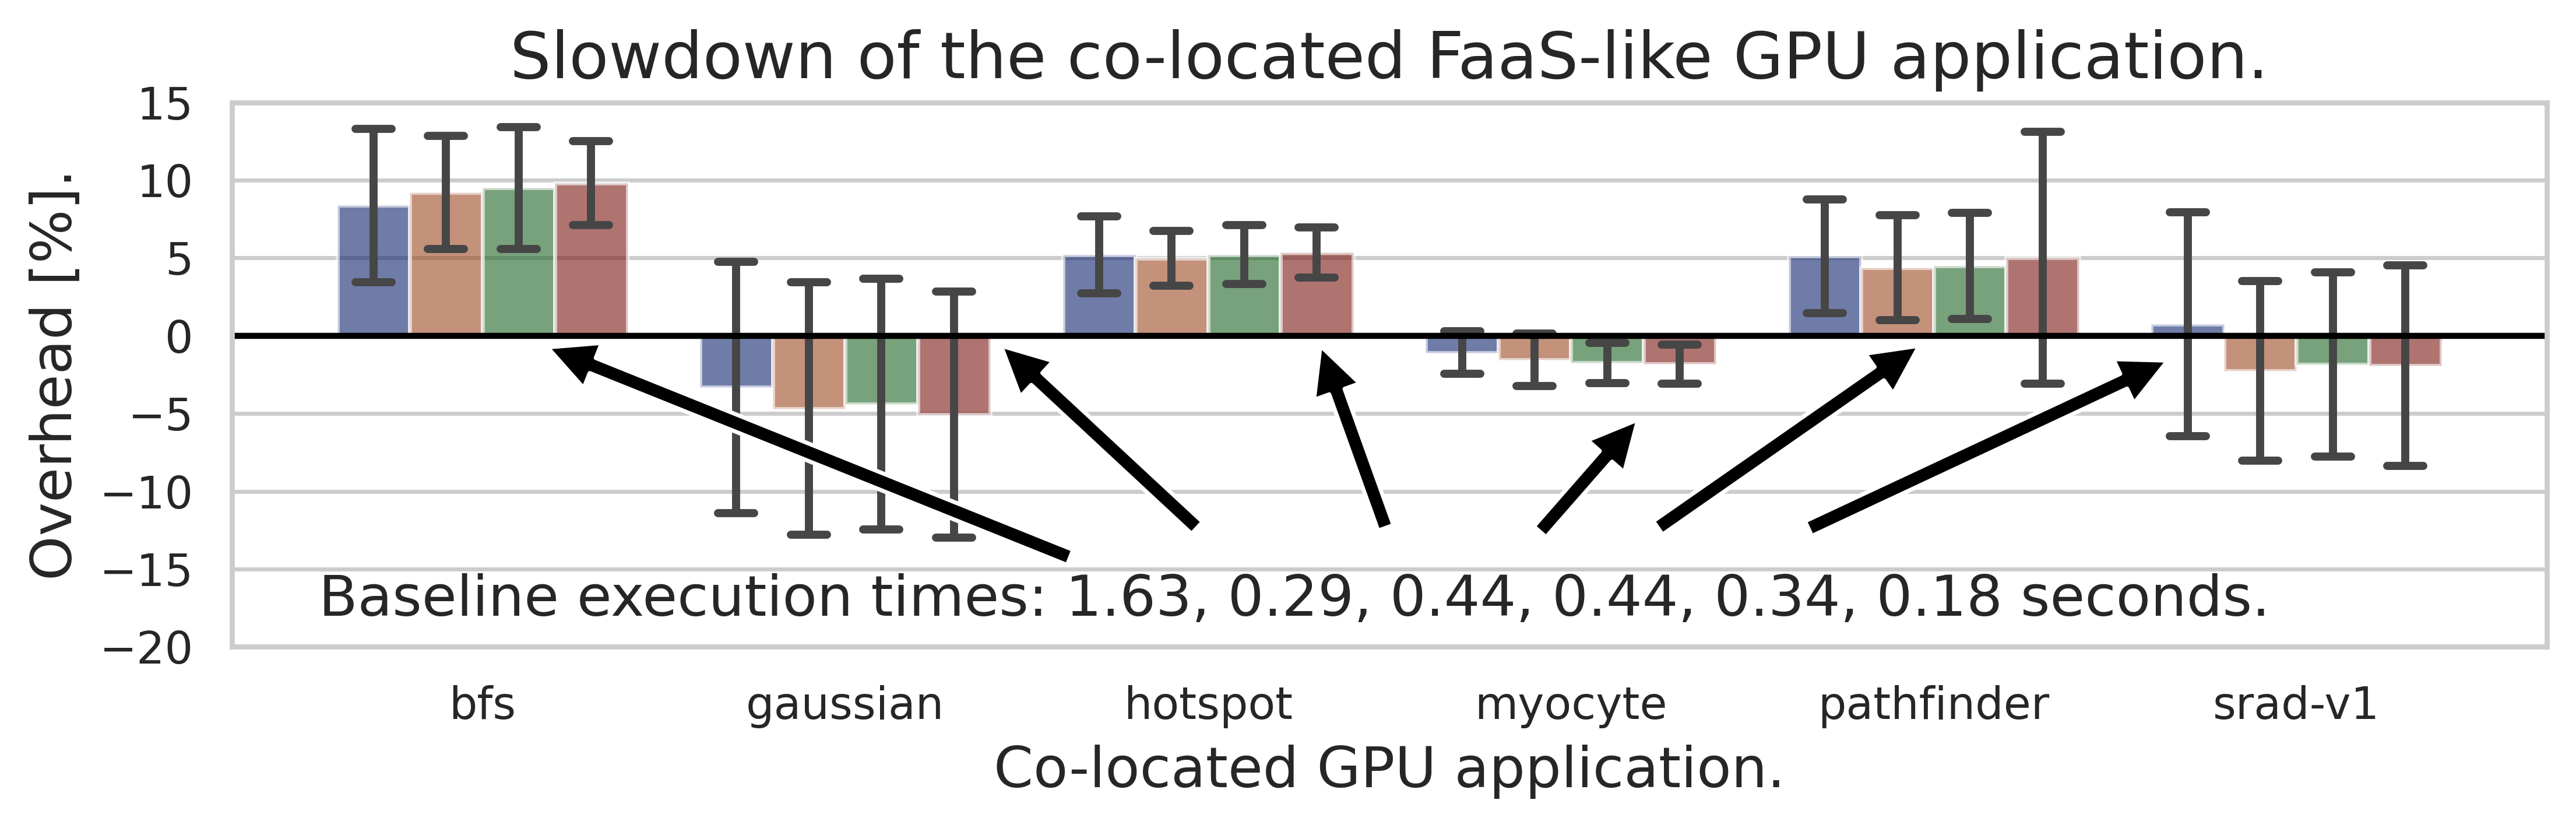

In [12]:
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df5,
#    x="app", y="app_slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6,#, height=6,
#    ax=ax
#)
g = barplot_err(y="rescaled_app_slowdown", x="app", yerr="rescaled_app_slowdown_dev", hue="lulesh_size",
                data=df5,palette="dark", alpha=.6, capsize=0.1)
g.set_title('Slowdown of the co-located FaaS-like GPU application.',fontsize=16)
g.set_xlabel('Co-located GPU application.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.legend(title='LULESH problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-20,15])
g.set_yticks([-20, -15, -10, -5, 0, 5, 10, 15])

g.legend().set_visible(False)
plt.annotate("Baseline execution times: 1.63, 0.29, 0.44, 0.44, 0.34, 0.18 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(-0.45, -18), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(0.1, 0),  #xycoords='data',
            xytext=(1.7, -15),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(1.4, 0),  #xycoords='data',
            xytext=(2, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(2.3, 0),  #xycoords='data',
            xytext=(2.5, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(3.2, -5),  #xycoords='data',
            xytext=(2.9, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4, 0),  #xycoords='data',
            xytext=(3.2, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4.7, -1),  #xycoords='data',
            xytext=(3.6, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "gpu", "colocation_gpu_lulesh_nas.pdf"), bbox_inches='tight',pad_inches = 0, transparent=False)

# Plot LULESH for Poster

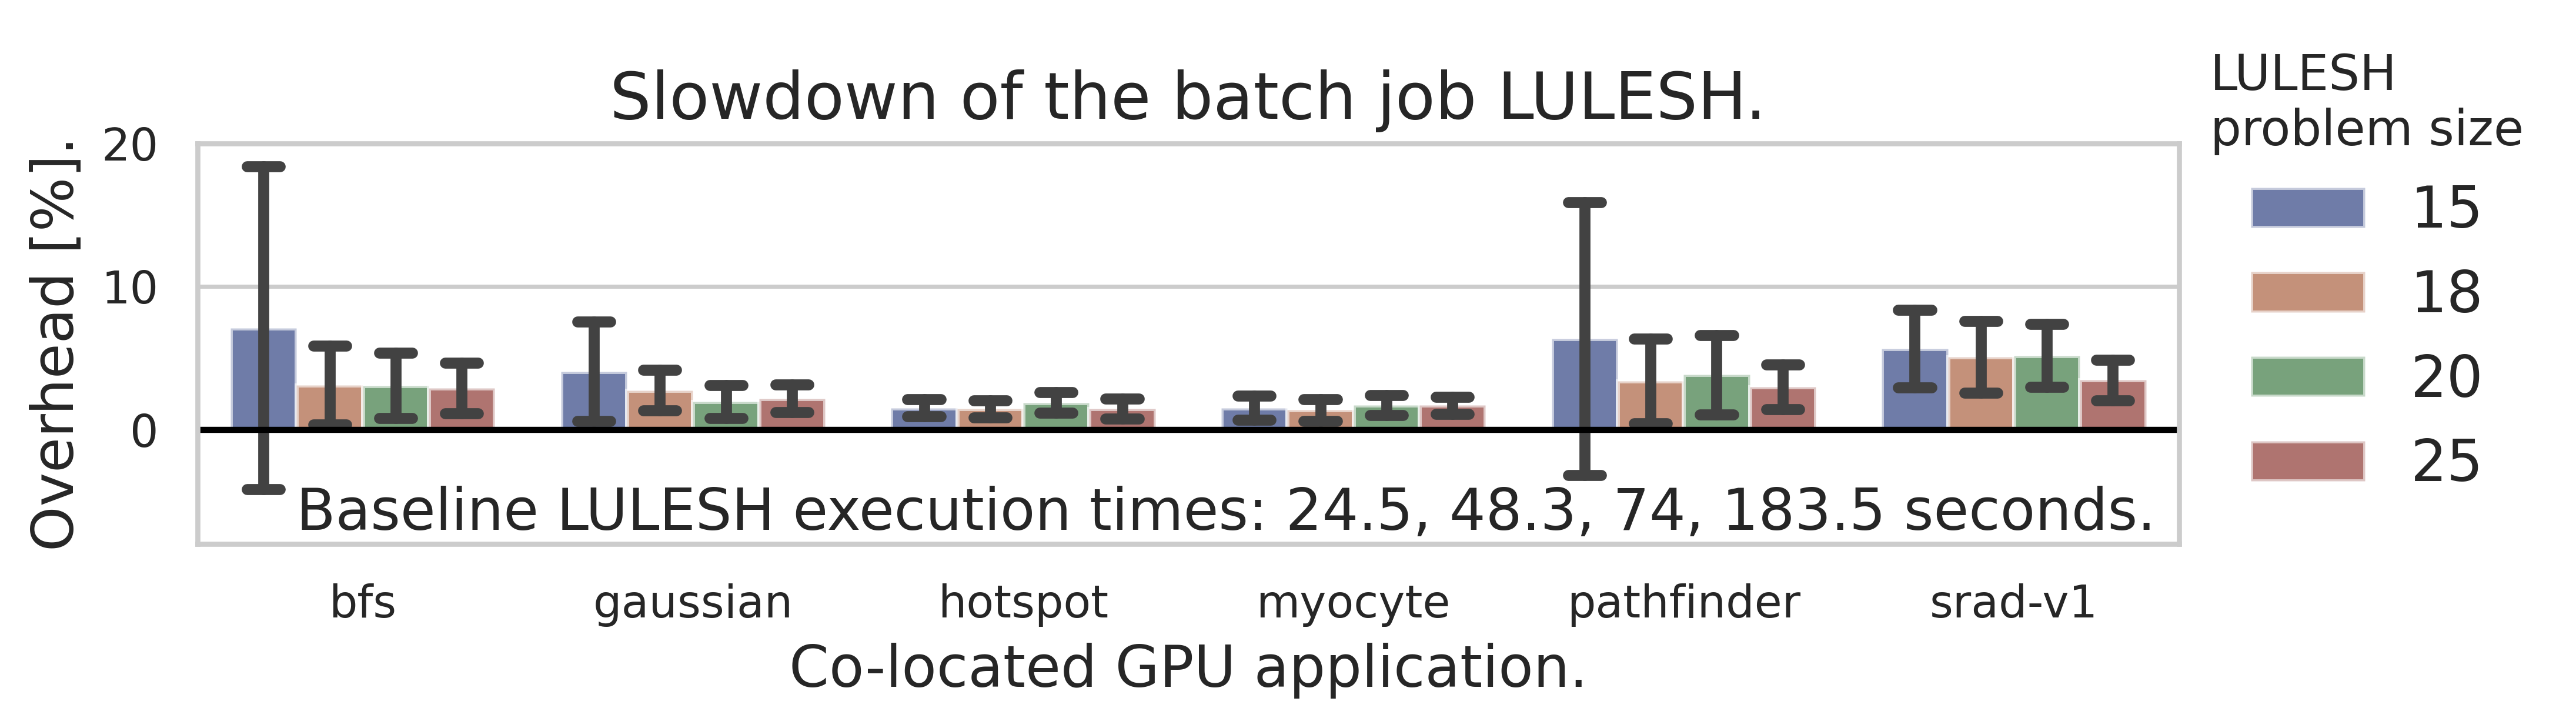

In [10]:

sns.set_style("whitegrid")
sns.set_context("notebook")
fig = plt.figure(figsize=(9,2.5))
ax = fig.gca()
#g = sns.barplot(
#    data=df5,
#    x="app", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)

g = barplot_err(y="rescaled_slowdown", x="app", yerr="rescaled_slowdown_dev", hue="lulesh_size",
                data=df5,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located GPU application.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(
    title='LULESH\nproblem size',
    fontsize=14,
    ncol=1,
    bbox_to_anchor=(1.2, 0),
    loc="lower right",
    frameon=False
)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-8,20])

plt.annotate("Baseline LULESH execution times: 24.5, 48.3, 74, 183.5 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(1, -2),  #xycoords='data',
            xytext=(-0.2, -7), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


#plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots',"colocation_gpu_lulesh_poster.pdf"), bbox_inches='tight',pad_inches = 0, transparent=False)


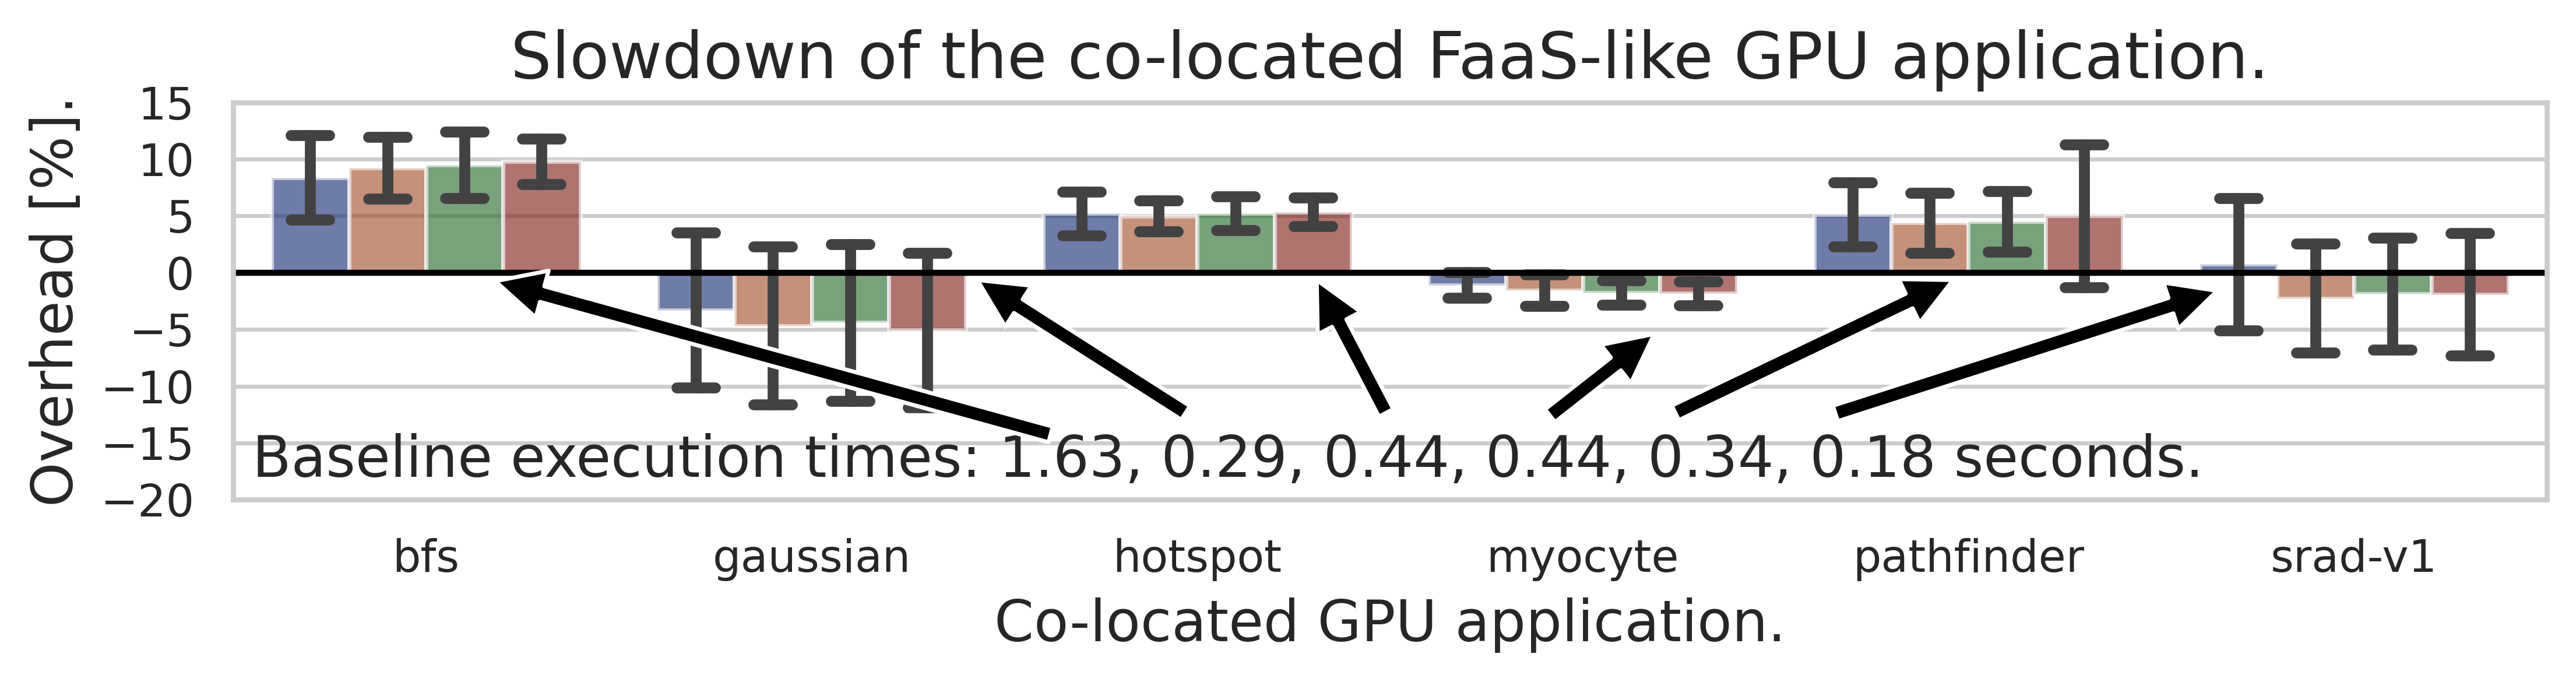

In [11]:
fig = plt.figure(figsize=(9,2.5))
ax = fig.gca()
#g = sns.barplot(
#    data=df5,
#    x="app", y="app_slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6,#, height=6,
#    ax=ax
#)
g = barplot_err(y="rescaled_app_slowdown", x="app", yerr="rescaled_app_slowdown_dev", hue="lulesh_size",
                data=df5,palette="dark", alpha=.6, capsize=0.1)
g.set_title('Slowdown of the co-located FaaS-like GPU application.',fontsize=16)
g.set_xlabel('Co-located GPU application.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.legend(title='LULESH problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-20,15])
g.set_yticks([-20, -15, -10, -5, 0, 5, 10, 15])

g.legend().set_visible(False)
plt.annotate("Baseline execution times: 1.63, 0.29, 0.44, 0.44, 0.34, 0.18 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(-0.45, -18), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(0.1, 0),  #xycoords='data',
            xytext=(1.7, -15),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(1.4, 0),  #xycoords='data',
            xytext=(2, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(2.3, 0),  #xycoords='data',
            xytext=(2.5, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(3.2, -5),  #xycoords='data',
            xytext=(2.9, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4, 0),  #xycoords='data',
            xytext=(3.2, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4.7, -1),  #xycoords='data',
            xytext=(3.6, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_gpu_lulesh_nas_poster.pdf"), bbox_inches='tight',pad_inches = 0, transparent=False)